In [3]:
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader, Dataset
from os import cpu_count

batch_size = 4
num_workers = cpu_count() or 1

def data_loader(dataset: Dataset, shuffle = False) -> DataLoader:
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

classes = ('Bao', 'Bua', 'Keo')

images = datasets.ImageFolder('./data', transform=transforms.ToTensor())

train, validation, test = random_split(dataset=images, lengths=[0.7, 0.2, 0.1])
print(f"train: {len(train)}, val: {len(validation)}, test: {len(test)}")

train_loader = data_loader(train, shuffle=True)
test_loader = data_loader(test)
validation_loader = data_loader(validation)

images, labels = next(iter(test_loader))

print(f"batch size: {images.size()}, labels: {labels}")

/home/gingdev/Code/python/gesture/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


train: 211, val: 60, test: 30
batch size: torch.Size([4, 3, 32, 32]), labels: tensor([1, 0, 0, 0])


In [4]:
from pytorch_lightning import LightningModule
from torch import nn, Tensor
from torch.optim import Optimizer, Adam
from torchmetrics.functional import accuracy
from typing import TypedDict

class Output(TypedDict):
    y: Tensor
    y_hat: Tensor

class ComputeLoss(TypedDict):
    loss: Tensor
    output: Output

class Network(LightningModule):
    def __init__(self) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.ReLU(),
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 3)
        )
    
    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)
    
    def share_step(self, batch) -> ComputeLoss:
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.cross_entropy(y_hat, y)
        return {'loss': loss, 'output': {'y': y, 'y_hat': y_hat}}

    def training_step(self, batch, batch_idx):
        return self.share_step(batch)

    def validation_step(self, batch, batch_idx):
        ret = self.share_step(batch)
        self.log("val_loss", ret['loss'])
        return ret

    def test_step(self, batch, _):
        ret = self.share_step(batch)
        acc = accuracy(ret['output']['y_hat'], ret['output']['y'], task="multiclass", num_classes=len(classes))
        metrics = {"test_acc": acc, "test_loss": ret['loss']}
        self.log_dict(metrics)

        return metrics

    def configure_optimizers(self) -> Optimizer:
        optimizer = Adam(self.parameters(), lr=0.001)

        return optimizer


In [5]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs", name="Group_1")

network = Network()

trainer = Trainer(
    max_epochs=4,
    callbacks=[EarlyStopping(monitor="val_loss", mode="min")],
    logger=logger
)

trainer.fit(model=network, train_dataloaders=train_loader, val_dataloaders=validation_loader)
trainer.test(model=network, dataloaders=test_loader)
trainer.save_checkpoint('./gesture.ckpt')

print("Training finished.")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/Group_1

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 61.4 K
------------------------------------
61.4 K    Trainable params
0         Non-trainable params
61.4 K    Total params
0.246     Total estimated model params size (MB)


Epoch 3: 100%|██████████| 68/68 [00:01<00:00, 61.36it/s, loss=0.000185, v_num=0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 120.65it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │   2.872977165679913e-05   │
└───────────────────────────┴───────────────────────────┘

Training finished.


In [6]:
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from typing import Any

def imshow(img: Tensor):
    npimg: NDArray[Any] = img.numpy()
    npimg = npimg.transpose((1,2,0))
    plt.imshow(npimg)
    plt.show()

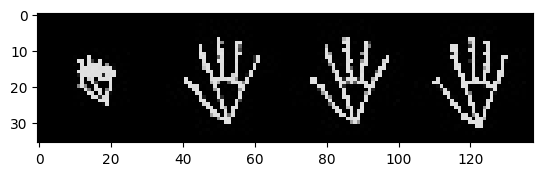

Truth: Bua Bao Bao Bao
Predicted:  Bua   Bao   Bao   Bao  


In [7]:
import torch
from torchvision.utils import make_grid

network.load_from_checkpoint('./gesture.ckpt')

images, labels = next(iter(test_loader))
imshow(make_grid(images))

print('Truth:', ' '.join(f'{classes[labels[i]]}' for i in range(batch_size)))

network.load_from_checkpoint('./gesture.ckpt')

with torch.no_grad():
    outputs = network(images)
    _, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))


In [11]:
%load_ext tensorboard
%tensorboard --logdir ./tb_logs